In [1]:
!pip3 install pandas numpy seaborn matplotlib scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Cargar datos

In [19]:
df = pd.read_csv('./data/chicago_crime_data.csv')
df.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,14027240,JJ487438,2025-11-13T00:00:00.000,005XX W ROSCOE ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,44.0,6.0,7,1171895.0,1922696.0,2025,2025-11-20T15:47:13.000,41.943335,-87.643600,"{'latitude': '41.943334801', 'longitude': '-87..."
1,14032816,JJ494286,2025-11-13T00:00:00.000,060XX S TALMAN AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,16.0,66.0,7,1159744.0,1864469.0,2025,2025-11-20T15:47:13.000,41.783814,-87.689865,"{'latitude': '41.783813711', 'longitude': '-87..."
2,14028485,JJ489008,2025-11-13T00:00:00.000,061XX N SEELEY AVE,0760,BURGLARY,BURGLARY FROM MOTOR VEHICLE,VEHICLE NON-COMMERCIAL,False,False,...,40.0,2.0,6,1161552.0,1940595.0,2025,2025-11-20T15:47:13.000,41.992673,-87.681115,"{'latitude': '41.992672556', 'longitude': '-87..."
3,14028184,JJ488595,2025-11-13T00:00:00.000,014XX W 47TH ST,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,RESTAURANT,False,False,...,15.0,61.0,11,1167315.0,1873576.0,2025,2025-11-20T15:47:13.000,41.808646,-87.661846,"{'latitude': '41.808645557', 'longitude': '-87..."
4,14029403,JJ490135,2025-11-13T00:00:00.000,024XX S WASHTENAW AVE,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,25.0,30.0,5,1158758.0,1887434.0,2025,2025-11-20T15:47:13.000,41.846853,-87.692853,"{'latitude': '41.846852738', 'longitude': '-87..."


# Procesar datos

## 1. Eliminar columnas con leakge

In [20]:
columns_to_delete = [
    'id',                  # identificador único
    'case_number',         # también único
    'updated_on',          # fecha de actualización del registro (leakage futuro)
    'fbi_code',            # redundante con primary_type
    'iucr',                # código muy granular, casi único
    'location',            # string con coordenadas → ya tenemos lat/lon
    'x_coordinate',        # mismo que longitude
    'y_coordinate',        # mismo que latitude
]

df = df.drop(columns=columns_to_delete, errors='ignore')

## 2. Conversion de tipos

In [21]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

df['year'] = df['year'].astype(int)

## 3. Feature Engineering

In [22]:
df['hour']         = df['date'].dt.hour
df['month']        = df['date'].dt.month
df['day_of_week']  = df['date'].dt.day_of_week          # 0=lunes, 6=domingo
df['is_weekend']   = df['day_of_week'].isin([5, 6]).astype(int)
df['is_night']     = df['hour'].isin([22,23,0,1,2,3,4,5]).astype(int)
df['is_summer']    = df['month'].isin([6,7,8]).astype(int)

df['downtown_proximity'] = np.sqrt((df['latitude'] - 41.8781)**2 + (df['longitude'] + 87.6298)**2)

df['night_and_weekend'] = df['is_night'] * df['is_weekend']
df['domestic_battery'] = ((df['primary_type'] == 'BATTERY') & (df['domestic'] == True)).astype(int)

## 4. Limpieza final de nulos

In [23]:
plt.style.use('default')
sns.set_palette("husl")

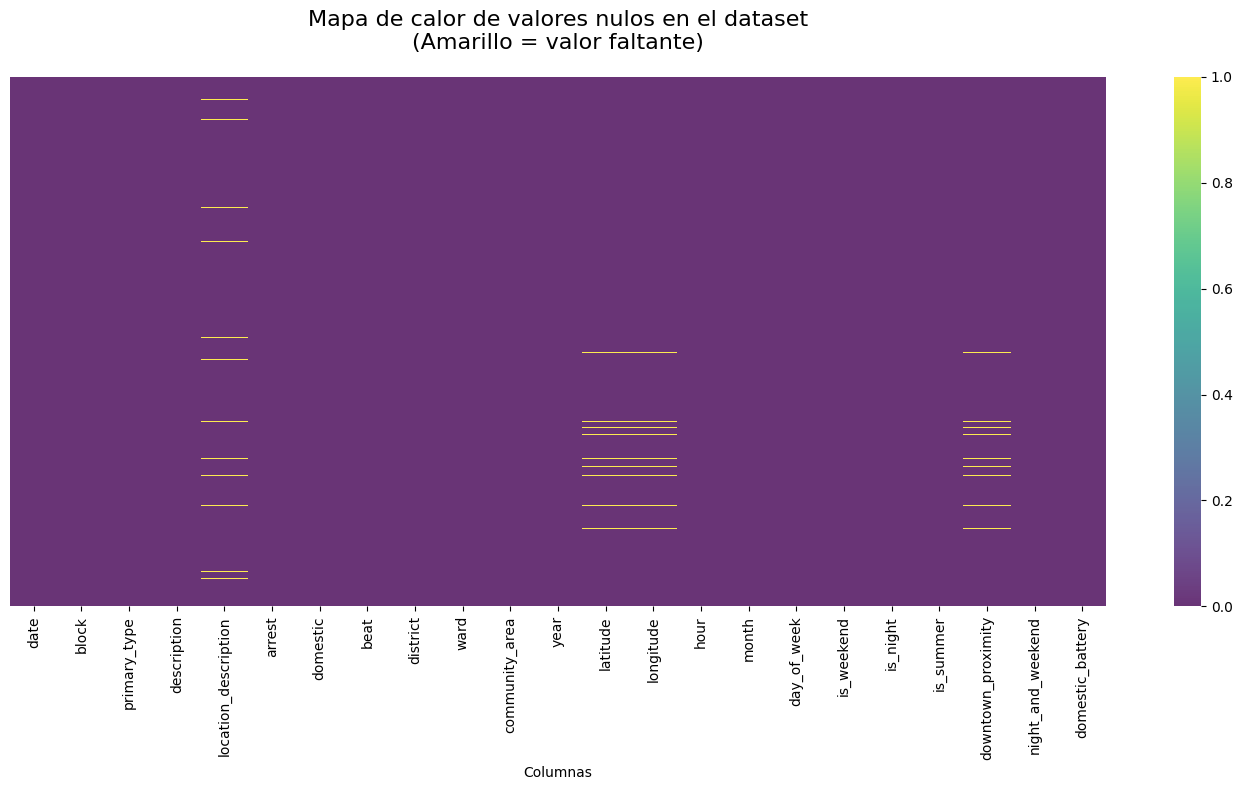

In [24]:
plt.figure(figsize=(14, 8))
sns.heatmap(df.isnull(), 
            cbar=True, 
            yticklabels=False, 
            cmap='viridis',
            alpha=0.8)
plt.title('Mapa de calor de valores nulos en el dataset\n(Amarillo = valor faltante)', 
          fontsize=16, pad=20)
plt.xlabel('Columnas')
plt.tight_layout()
plt.show()

In [25]:
nulos = df.isnull().sum()
porcentaje_nulos = (nulos / len(df) * 100).round(2)

print("\nPorcentaje de nulos por columna:")
for col, pct in porcentaje_nulos[porcentaje_nulos > 0].items():
    print(f"  → {col}: {pct}%")


Porcentaje de nulos por columna:
  → location_description: 2.18%
  → community_area: 0.01%
  → latitude: 2.26%
  → longitude: 2.26%
  → downtown_proximity: 2.26%


In [26]:
# 1. location_description → pocos nulos → moda + categoría "UNKNOWN"
df['location_description'] = df['location_description'].fillna("UNKNOWN")

# 2. community_area → pocos nulos → imputar con moda (es categórico)
df['community_area'] = df['community_area'].fillna(df['community_area'].mode()[0]) 

# 3. Coordenadas (latitude, longitude, downtown_proximity)
coords_cols = ['latitude', 'longitude', 'downtown_proximity']
df[coords_cols] = df[coords_cols].astype(float)
imputer = KNNImputer(n_neighbors=5, weights='uniform')
df[coords_cols] = imputer.fit_transform(df[coords_cols])

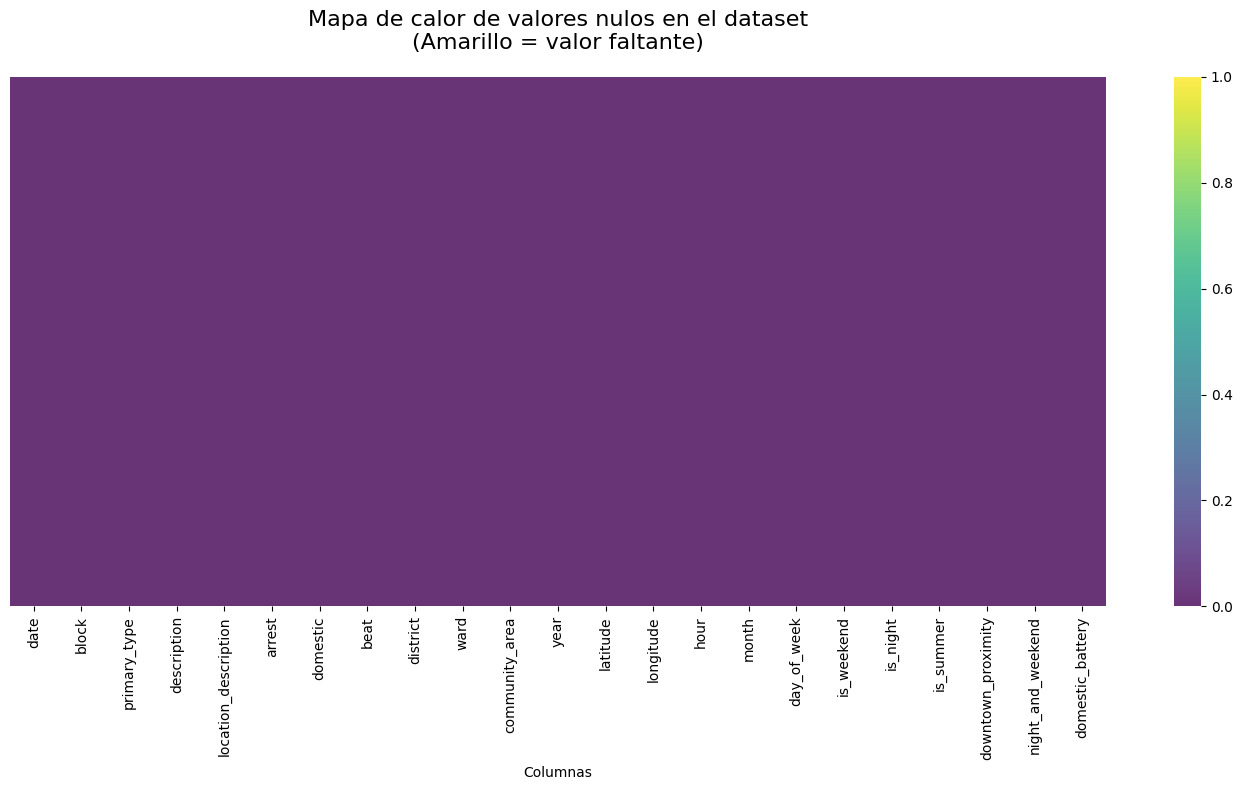

In [27]:
plt.figure(figsize=(14, 8))
sns.heatmap(df.isnull(), 
            cbar=True, 
            yticklabels=False, 
            cmap='viridis',
            alpha=0.8)
plt.title('Mapa de calor de valores nulos en el dataset\n(Amarillo = valor faltante)', 
          fontsize=16, pad=20)
plt.xlabel('Columnas')
plt.tight_layout()
plt.show()

## 5. Guardar datos

In [28]:
output_file = "./data/chicago_crime_data_processed.csv"
df.to_csv(output_file, index=False)